In [152]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt

# Setting default parameters
plt.rcParams["figure.figsize"] = [10, 5] # Figure sizes for Matplotlib 
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["blue", "green", "red", "orange", "purple", "magenta"]) # Color for plotting

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

In [69]:
# Checking data filenames
DATA_FILENAMES = glob.glob("data/*.csv")
DATA_FILENAMES

['data/asset_details.csv',
 'data/supplemental_train.csv',
 'data/train.csv',
 'data/example_test.csv']

In [70]:
# Checking that we only have the 4 files
assert len(DATA_FILENAMES) == 4

In [145]:
# Importing and storing asset details
ASSET_DETAILS = pd.read_csv(filepath_or_buffer="data/asset_details.csv", index_col="Asset_ID")
ASSET_DETAILS.T

Asset_ID,2,0,1,5,7,6,9,11,13,12,3,8,10,4
Weight,2.397895,4.304065,6.779922,1.386294,2.079442,5.894403,2.397895,1.609438,1.791759,2.079442,4.406719,1.098612,1.098612,3.555348
Asset_Name,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin


In [146]:
# Retrieving asset ids
ASSET_IDs = sorted(list(ASSET_DETAILS.index))
ASSET_IDs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [203]:
# Declaring utils functions

def get_asset_id(asset_name: str) -> int:
    """
    Function returning the asset id from a given asset name
    """
    # Getting the list of asset names
    LIST_ASSET_NAMES = ASSET_DETAILS['Asset_Name'].to_numpy()
    
    # Checking if the asset name is correct
    if str(asset_name) not in LIST_ASSET_NAMES:
        raise Exception(f"The given asset name is unknown\nPlease use one from: {LIST_ASSET_NAMES}")
    
    # Returning the corresponding asset id
    return list(ASSET_DETAILS.index[ASSET_DETAILS["Asset_Name"] == str(asset_name)])[0]

def get_asset_name(asset_id: int) -> str:
    """
    Function returning the asset name from a given asset id
    """
    if int(asset_id) not in ASSET_IDs:
        raise Exception(f"The given asset id is unknown\nPlease use one from: {ASSET_IDs}")
    
    return ASSET_DETAILS["Asset_Name"][asset_id]

In [204]:
# Example
get_asset_id("TRON")

13

In [72]:
# Importing training dataset
TRAIN = pd.read_csv(filepath_or_buffer="data/train.csv")

In [168]:
# Hashmap of train datasets for each asset id
df_train = {asset_id: None for asset_id in ASSET_IDs}

# For each asset id, perform the pre-processing
for asset_id in ASSET_IDs:
    print(f"--> Processing Asset #{asset_id} \t ({get_asset_name(asset_id)})")
    
    # Retrieving the corresponding data rows
    df_train[asset_id] = TRAIN[TRAIN["Asset_ID"] == asset_id]
    
    # Removing the Asset_ID column (useless now)
    try:
        df_train[asset_id].drop(["Asset_ID", "Target"], axis=1, inplace=True)
    except:
        pass
    
    # Converting the timestamp column
    df_train[asset_id]["timestamp"] = pd.to_datetime(arg=df_train[asset_id]["timestamp"], 
                                                     unit="s", 
                                                     errors="ignore")
    # Setting the timestamp column as index column
    df_train[asset_id].set_index(["timestamp"], inplace=True)

--> Processing Asset #0 	 (Binance Coin)
--> Processing Asset #1 	 (Bitcoin)
--> Processing Asset #2 	 (Bitcoin Cash)
--> Processing Asset #3 	 (Cardano)
--> Processing Asset #4 	 (Dogecoin)
--> Processing Asset #5 	 (EOS.IO)
--> Processing Asset #6 	 (Ethereum)
--> Processing Asset #7 	 (Ethereum Classic)
--> Processing Asset #8 	 (IOTA)
--> Processing Asset #9 	 (Litecoin)
--> Processing Asset #10 	 (Maker)
--> Processing Asset #11 	 (Monero)
--> Processing Asset #12 	 (Stellar)
--> Processing Asset #13 	 (TRON)


In [205]:
# Displaying a DataFrame
df_train[get_asset_id("Bitcoin")]

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842
...,...,...,...,...,...,...,...
2021-09-20 23:56:00,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499
2021-09-20 23:57:00,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084
2021-09-20 23:58:00,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693


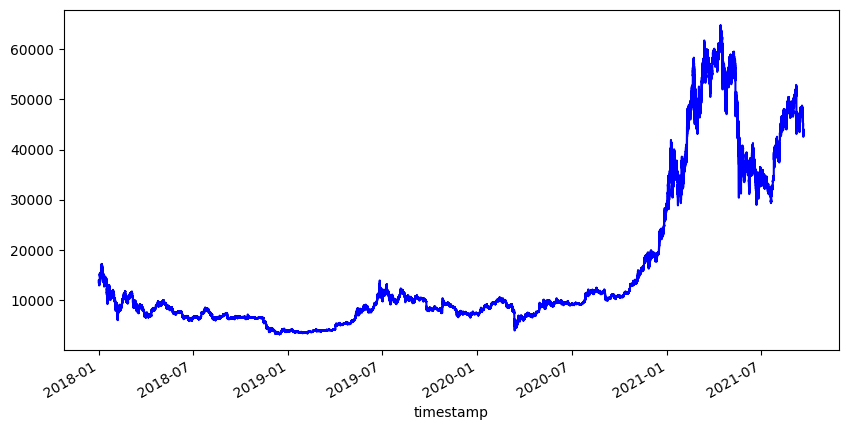

In [206]:
# Displaying a random dataframe (train)
_ = df_train[get_asset_id("Bitcoin")]["Open"].plot()

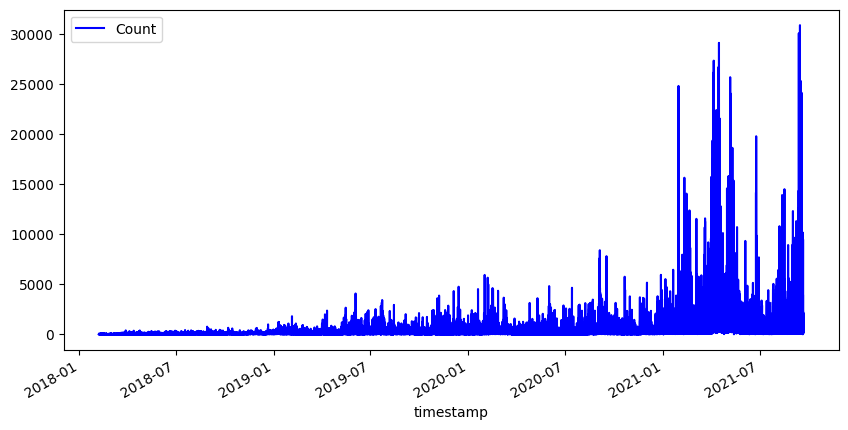

In [170]:
# Declaring the column labels
OHLC = ["Open", "High", "Low", "Close"]
OHLCV = OHLC + ["Volume"]
TRADING_ACTIVITY = ["Count"]
VWAP = ["VWAP"]
TARGET = ["Target"]

_ = df_train[get_asset_id("TRON")][TRADING_ACTIVITY].plot()

In [96]:
# Checking the sum of the number of rows for each asset id is equal to the number of rows from the original dataset
# ==> No loss
assert sum([df_train[k].shape[0] for k in ASSET_IDs]) == TRAIN.shape[0]

In [200]:
# Getting memory usage

# Computing the memory usage of each DataFrame
MEM_USAGE = {asset_id: df_train[asset_id].memory_usage(index=True).sum()/10**6 for asset_id in ASSET_IDs}

# Computing the global memory usage
GLOBAL_MEM_USAGE = sum(list(MEM_USAGE.values()))/10**3
print(f"Global mem. usage: \t {GLOBAL_MEM_USAGE :.1f} GB")

Global mem. usage: 	 1.6 GB


In [161]:
# Importing second train
TRAIN_2 = pd.read_csv(filepath_or_buffer="data/supplemental_train.csv")

In [201]:
TRAIN_2

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1632182460,3,561.0,2.079028,2.080605,2.072000,2.076458,2.804627e+05,2.075869,0.003085
1,1632182460,2,169.0,541.006000,541.200000,539.700000,540.722000,1.889432e+02,540.716930,-0.000607
2,1632182460,0,400.0,363.737500,363.900000,363.000000,363.654000,8.792685e+02,363.499554,-0.019375
3,1632182460,1,1933.0,42986.143333,43001.000000,42898.000000,42947.065566,9.183861e+01,42942.976718,-0.000374
4,1632182460,4,348.0,0.208326,0.208400,0.207800,0.208200,1.051337e+06,0.208077,-0.001233
...,...,...,...,...,...,...,...,...,...,...
2518273,1642982400,9,214.0,112.293000,112.470000,111.840000,111.983333,1.243860e+03,112.127619,NaN
2518274,1642982400,10,25.0,1833.565000,1834.700000,1831.050000,1833.018333,4.190290e+00,1833.173692,NaN
2518275,1642982400,13,235.0,0.057520,0.057618,0.057389,0.057478,8.988253e+05,0.057519,NaN
2518276,1642982400,12,492.0,0.200940,0.201066,0.199352,0.200093,2.983796e+06,0.200413,NaN
